Targets:   0%|          | 0/2 [00:00<?, ?it/s]

Methods for Vad:   0%|          | 0/12 [00:00<?, ?it/s]

Methods for Mad:   0%|          | 0/12 [00:00<?, ?it/s]

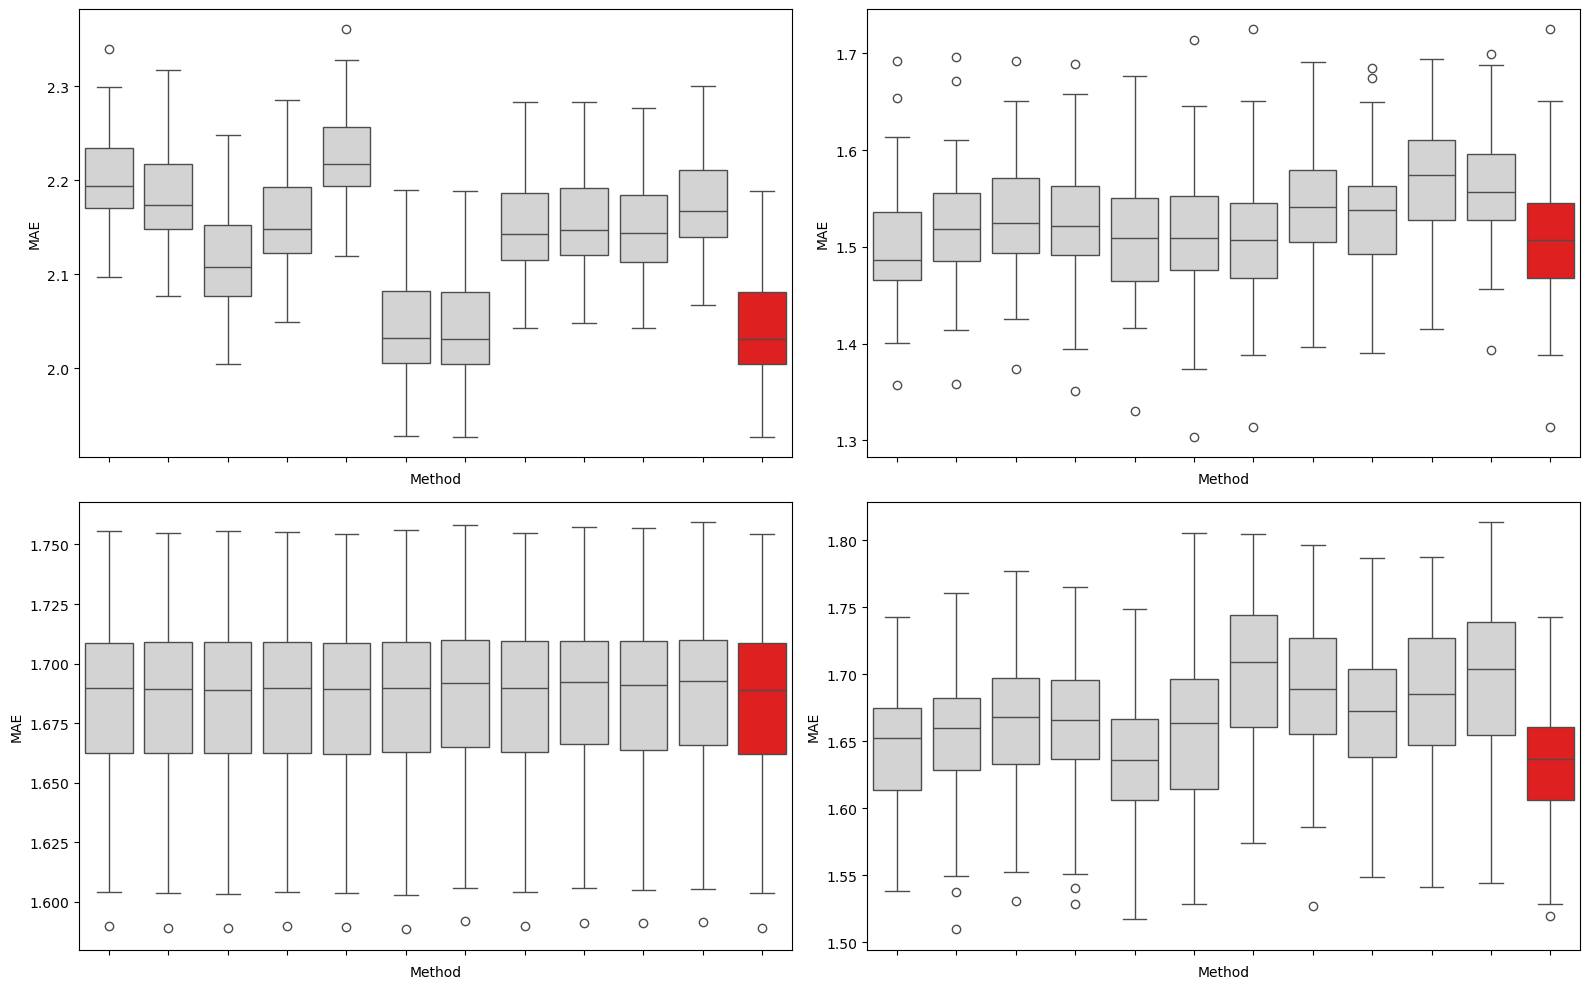

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import tqdm
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# =======================
# 1. 读取数据
# =======================

ranks_mad = pd.read_csv("integrated_outputs/Mad/fused_results/ranks_with_fused.csv")
ranks_vad = pd.read_csv("integrated_outputs/Vad/fused_results/ranks_with_fused.csv")
data = pd.read_excel("整合数据/final_data_cleaned.xlsx")

data = data.drop(columns=["Sample"])
targets = ["Vad", "Mad"]

methods_mad = [c for c in ranks_mad.columns if c.endswith("_Rank")]
methods_vad = [c for c in ranks_vad.columns if c.endswith("_Rank")]

# 固定TopN
top_n = 70
# 种子列表
random_seeds = [94,78,90,25,31,51,43,48,95,83]

results = []

# =======================
# 2. 实验过程（不同随机种子）
# =======================
for target in tqdm(targets, desc="Targets"):
    y = data[target].values
    if target == "Mad":
        ranks = ranks_mad
        methods = methods_mad
    else:
        ranks = ranks_vad
        methods = methods_vad

    for method in tqdm(methods, desc=f"Methods for {target}", leave=False):
        sorted_wavelengths = ranks.sort_values(by=method)["Wavelength"].values
        selected_wavelengths = sorted_wavelengths[:top_n]
        X = data[selected_wavelengths].values

        for seed in random_seeds:
            # 反向 k 折交叉验证：每折用一个fold做训练（小），其余fold做测试（大）
            kf = KFold(n_splits=5, shuffle=True, random_state=seed)

            for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
                # 交换索引以实现“小训练集、大测试集”
                X_train, y_train = X[test_idx], y[test_idx]
                X_test, y_test = X[train_idx], y[train_idx]

                for model_name in ["SVR", "MLP", "KNN"]:
                    if model_name == "SVR":
                        model = SVR(kernel="rbf", C=1.0, epsilon=0.1)
                    elif model_name == "MLP":
                        model = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
                    else:
                        # 保证KNN的邻居数不超过训练样本数，避免小样本下报错
                        n_neighbors = min(5, len(y_train)) if len(y_train) > 0 else 1
                        model = KNeighborsRegressor(n_neighbors=n_neighbors)

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                    R2 = r2_score(y_test, y_pred)
                    rmse = mean_squared_error(y_test, y_pred, squared=False)
                    mae = mean_absolute_error(y_test, y_pred)

                    results.append({
                        "Target": target,
                        "Model": model_name,
                        "Method": method.replace("_Rank",""),
                        "Seed": seed,
                        "Fold": fold_idx,
                        "R2": R2,
                        "RMSE": rmse,
                        "MAE": mae
                    })

df_results = pd.DataFrame(results)
df_results.to_csv("stability_results/feature_selection_stability_cv.csv", index=False)


# =======================
# 3. 可视化稳定性
# =======================
def plot_stability(ax, df, target, model, metric="R2"):
    methods = df["Method"].unique()
    palette = {m: ("red" if m.lower()=="fused" else "lightgray") for m in methods}

    sns.boxplot(
        data=df[(df["Target"]==target) & (df["Model"]==model)],
        x="Method", y=metric, palette=palette, ax=ax
    )
    # ax.set_title(f"{target} - {model} ({metric})", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# 画四个子图
fig, axes = plt.subplots(2, 2, figsize=(16,10))

plot_stability(axes[0,0], df_results, "Mad", "SVR", metric="MAE")
plot_stability(axes[0,1], df_results, "Mad", "KNN", metric="MAE")
plot_stability(axes[1,0], df_results, "Vad", "SVR", metric="MAE")
plot_stability(axes[1,1], df_results, "Vad", "KNN", metric="MAE")

plt.tight_layout()
plt.savefig("stability_results/stability_comparison.svg", format="svg")
plt.show()


Targets:   0%|          | 0/2 [00:00<?, ?it/s]

Methods for Vad:   0%|          | 0/12 [00:00<?, ?it/s]

TrainSize for Vad-PLS_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-RandomForest_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-XGBoost_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-LightGBM_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-CatBoost_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-Spearman_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-Pearson_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-dCor_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-HSIC_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-MI_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-PartialCorr_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Vad-Fused_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

Methods for Mad:   0%|          | 0/12 [00:00<?, ?it/s]

TrainSize for Mad-PLS_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-RandomForest_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-XGBoost_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-LightGBM_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-CatBoost_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-Spearman_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-Pearson_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-dCor_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-HSIC_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-MI_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-PartialCorr_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

TrainSize for Mad-Fused_Rank:   0%|          | 0/4 [00:00<?, ?it/s]

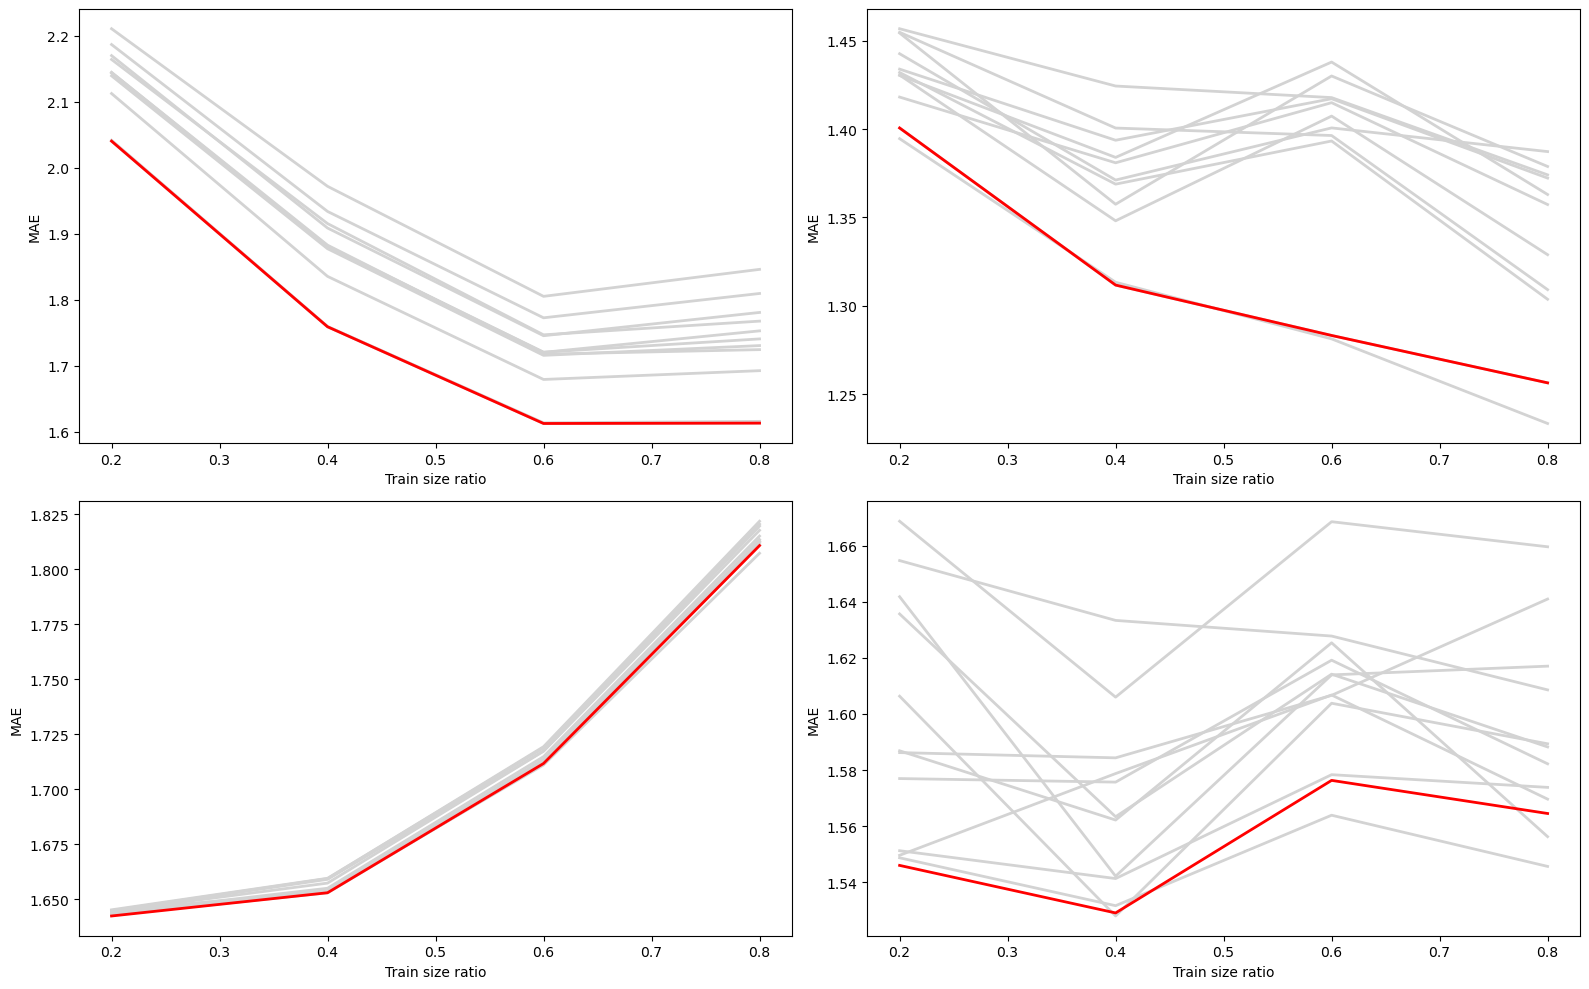

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# =======================
# 1. 读取数据
# =======================

ranks_mad = pd.read_csv("integrated_outputs/Mad/fused_results/ranks_with_fused.csv")
ranks_vad = pd.read_csv("integrated_outputs/Vad/fused_results/ranks_with_fused.csv")
data = pd.read_excel("整合数据/final_data_cleaned.xlsx")

data = data.drop(columns=["Sample"])
targets = ["Vad", "Mad"]

methods_mad = [c for c in ranks_mad.columns if c.endswith("_Rank")]
methods_vad = [c for c in ranks_vad.columns if c.endswith("_Rank")]

top_n = 70
seed = 78  
train_sizes = np.linspace(0.2, 0.8, 4)  # 训练集占比从 0.1 到 0.9

results = []


# =======================
# 2. 实验过程（不同训练集比例）
# =======================
for target in tqdm(targets, desc="Targets"):
    y = data[target].values
    if target == "Mad":
        ranks = ranks_mad
        methods = methods_mad
    else:
        ranks = ranks_vad
        methods = methods_vad

    for method in tqdm(methods, desc=f"Methods for {target}", leave=False):
        sorted_wavelengths = ranks.sort_values(by=method)["Wavelength"].values
        selected_wavelengths = sorted_wavelengths[:top_n]
        X = data[selected_wavelengths].values

        for train_size in tqdm(train_sizes, desc=f"TrainSize for {target}-{method}", leave=False):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, train_size=train_size, random_state=seed
            )

            models = {
                "SVR": SVR(kernel="rbf", C=1.0, epsilon=0.1),
                "MLP": MLPRegressor(hidden_layer_sizes=(100,50), 
                                    max_iter=500, random_state=seed),
                "KNN": KNeighborsRegressor(n_neighbors=5),
            }

            for model_name, model in models.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                R2 = r2_score(y_test, y_pred)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                mae = mean_absolute_error(y_test, y_pred)

                results.append({
                    "Target": target,
                    "Model": model_name,
                    "Method": method.replace("_Rank",""),
                    "TrainSize": train_size,
                    "R2": R2,
                    "RMSE": rmse,
                    "MAE": mae
                })

df_results = pd.DataFrame(results)
df_results.to_csv("stability_results/train_size_curve.csv", index=False)


# =======================
# 3. 可视化：曲线图
# =======================
def plot_curve(ax, df, target, model, metric="R2"):
    methods = df["Method"].unique()
    palette = {m: ("red" if m.lower()=="fused" else "lightgray") for m in methods}

    sns.lineplot(
        data=df[(df["Target"]==target) & (df["Model"]==model)],
        x="TrainSize", y=metric, hue="Method", palette=palette,
        linewidth=2, ax=ax, legend=False
    )
    # ax.set_title(f"{target} - {model} ({metric})", fontsize=12)
    ax.set_xlabel("Train size ratio")
    ax.set_ylabel(metric)

# 四个子图
fig, axes = plt.subplots(2, 2, figsize=(16,10))

plot_curve(axes[0,0], df_results, "Mad", "SVR", metric="MAE")
plot_curve(axes[0,1], df_results, "Mad", "KNN", metric="MAE")
plot_curve(axes[1,0], df_results, "Vad", "SVR", metric="MAE")
plot_curve(axes[1,1], df_results, "Vad", "KNN", metric="MAE")

plt.tight_layout()
plt.savefig("stability_results/train_size_curve.svg", format="svg")
plt.show()


In [7]:

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns
from catboost import CatBoostRegressor
# =======================
# 4. TopN特征有效性网格实验（多模型）
# =======================
# 使用用户提供的模型配置，基于融合排序（Fused_Rank，如不存在则回退到首个排序方法），
# 评估不同TopN下的MAE（反向k折：小训练、大测试），并输出N×模型的MAE矩阵和热力图。

# 模型字典（CatBoost在环境不可用时将自动跳过）
models_prediction = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    # "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf", C=1.0, epsilon=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=200, random_state=42, verbose=0),
}


def build_model(name: str, train_len: int):
    # 在小训练折下动态约束KNN的邻居数，其他模型保持原样
    if name == "KNN":
        n_neighbors = min(5, train_len) if train_len > 0 else 1
        return KNeighborsRegressor(n_neighbors=n_neighbors)
    elif name == "SVR":
        return SVR(kernel="rbf", C=1.0, epsilon=0.1)
    elif name == "MLP":
        return MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
    elif name == "LinearRegression":
        return LinearRegression()
    elif name == "Ridge":
        return Ridge(alpha=1.0)
    elif name == "Lasso":
        return Lasso(alpha=0.01)
    elif name == "ElasticNet":
        return ElasticNet(alpha=0.01, l1_ratio=0.5)
    elif name == "RandomForest":
        return RandomForestRegressor(n_estimators=200, random_state=42)
    elif name == "ExtraTrees":
        return ExtraTreesRegressor(n_estimators=200, random_state=42)
    elif name == "GradientBoosting":
        return GradientBoostingRegressor(n_estimators=200, random_state=42)
    elif name == "CatBoost":
        return CatBoostRegressor(n_estimators=200, random_state=42, verbose=0)
    else:
        return None


for target in targets:
    # 选择对应的排序表
    if target == "Mad":
        ranks = ranks_mad
    else:
        ranks = ranks_vad

    # 优先使用融合排序列（含"fused"），否则回退到第一个排序方法
    rank_cols = [c for c in ranks.columns if c.endswith("_Rank")]
    fused_col = next((c for c in rank_cols if "fused" in c.lower()), rank_cols[0])
    sorted_wavelengths = ranks.sort_values(by=fused_col)["Wavelength"].values
    n_total = len(sorted_wavelengths)

    # TopN的网格（覆盖中间值与全部特征）；自动裁剪到可用特征上限
    N_grid = [10, 20, 30, 40, 50, 60, 70, 80, 100, 120, 150, 200]
    N_grid = [n for n in N_grid if n <= n_total]
    if n_total not in N_grid:
        N_grid.append(n_total)  # 作为"使用全部特征"的参照

    rows = []
    for N in tqdm(N_grid, desc=f"TopN grid for {target}"):
        XN = data[sorted_wavelengths[:N]].values
        y = data[target].values

        # 收集每个模型在多seed、多fold下的MAE并取平均
        mae_collect = {m: [] for m in models_prediction.keys()}

        for seed in random_seeds:
            kf = KFold(n_splits=5, shuffle=True, random_state=seed)
            for (train_idx, test_idx) in kf.split(XN):
                # 反向：用单fold训练，其余fold测试
                X_train, y_train = XN[test_idx], y[test_idx]
                X_test, y_test = XN[train_idx], y[train_idx]

                train_len = len(y_train)
                for model_name in list(models_prediction.keys()):
                    model = build_model(model_name, train_len)
                    if model is None:
                        continue
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    mae = mean_absolute_error(y_test, y_pred)
                    mae_collect[model_name].append(mae)

        # 计算平均MAE并落表
        for model_name, maes in mae_collect.items():
            if len(maes) == 0:
                continue
            rows.append({
                "Target": target,
                "N": N,
                "Model": model_name,
                "MAE": float(np.mean(maes))
            })

    df_grid = pd.DataFrame(rows)
    # 生成N×模型的矩阵并保存
    df_pivot = df_grid.pivot(index="N", columns="Model", values="MAE").sort_index()
    csv_path = f"stability_results/topN_mae_grid_{target}.csv"
    df_pivot.to_csv(csv_path)

    # 绘制热力图（带数值）
    plt.figure(figsize=(max(10, 0.8 * df_pivot.shape[1] + 4), max(6, 0.5 * df_pivot.shape[0] + 3)))
    sns.heatmap(df_pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"{target} TopN vs Models (MAE)")
    plt.xlabel("Models")
    plt.ylabel("Top N features")
    heatmap_path = f"stability_results/topN_mae_heatmap_{target}.svg"
    plt.tight_layout()
    plt.savefig(heatmap_path, format="svg")
    plt.show()


TopN grid for Vad:   0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
 # --------------- Section 5: Generate LaTeX table with min/second-min MAE ---------------
def generate_feature_selection_latex_table(
     csv_mad_path="stability_results/topN_mae_grid_Mad.csv",
     csv_vad_path="stability_results/topN_mae_grid_Vad.csv",
     topn_columns=(10, 20, 40, 50, 60, 70, 80, 100),
 ):
     """
     Read TopN×Model MAE CSVs for Mad and Vad, mark per-row min and second-min,
     and print a LaTeX tabularx table with bold (min) and underline (second-min).
     """
     df_mad = pd.read_csv(csv_mad_path)
     df_vad = pd.read_csv(csv_vad_path)
     if "N" in df_mad.columns:
         df_mad = df_mad.set_index("N")
     if "N" in df_vad.columns:
         df_vad = df_vad.set_index("N")
     # Determine 'All' as max N
     all_mad = int(df_mad.index.max())
     all_vad = int(df_vad.index.max())
     # Ensure numeric index
     df_mad.index = df_mad.index.astype(int)
     df_vad.index = df_vad.index.astype(int)
     # Models present in both CSVs (intersection to avoid missing values)
     models = [m for m in df_mad.columns if m in set(df_vad.columns)]
     # Compose header TopN list using provided list filtered by availability
     ns_common_mad = set(df_mad.index.tolist())
     ns_common_vad = set(df_vad.index.tolist())
     ns_selected = [n for n in topn_columns if (n in ns_common_mad and n in ns_common_vad)]
     # Append 'All' at the end
     col_labels = [str(n) for n in ns_selected] + ["All"]
     # Helper to format a numeric series with min and second-min highlighted
     def format_values(values):
         arr = np.array(values, dtype=float)
         if arr.size == 0:
             return []
         min_idx = int(np.argmin(arr))
         # Handle ties: second-min is the smallest index not equal to min_idx
         tmp = arr.copy()
         tmp[min_idx] = np.inf
         second_idx = int(np.argmin(tmp))
         out = []
         for i, v in enumerate(arr):
             s = f"{v:.3f}"
             if i == min_idx:
                 s = f"\\textbf{{{s}}}"
             elif i == second_idx:
                 s = f"\\underline{{{s}}}"
             out.append(s)
         return out
     # Begin LaTeX table
     lines = []
     lines.append("\\begin{table}")
     lines.append(" \\centering")
     lines.append(" \\caption{MAE of different models with Top-N feature subsets}")
     lines.append(" \\label{tab:feature_selection_mae}")
     lines.append(" \\small")
     lines.append(" \\newcolumntype{C}{>{\\centering\\arraybackslash}X}")
     lines.append(f" \\begin{{tabularx}}{{\\textwidth}}{{ll*{{{len(col_labels)}}}{{C}}}}")
     lines.append(" \\toprule")
     lines.append(f"         & TopN & {' & '.join([f'{c:>17}' for c in col_labels])} \\ ")
     # 添加一行示例占位（与用户示例一致的空列宽度）
     empty_cols = " & ".join([" " * 20 for _ in col_labels])
     lines.append(f" Model & Target & {empty_cols} \\ ")
     lines.append(" \\midrule")
     # Rows per model and target
     for model in models:
         # Mad row
         vals_mad = [df_mad.loc[n, model] for n in ns_selected] + [df_mad.loc[all_mad, model]]
         fmt_mad = format_values(vals_mad)
         lines.append(f" {model} & $M_{{ad}}$ & " + " & ".join([f"{s:>15}" for s in fmt_mad]) + " \\ ")
         # Vad row
         vals_vad = [df_vad.loc[n, model] for n in ns_selected] + [df_vad.loc[all_vad, model]]
         fmt_vad = format_values(vals_vad)
         lines.append(f"         & $V_{{ad}}$ & " + " & ".join([f"{s:>15}" for s in fmt_vad]) + " \\ ")
     lines.append(" \\bottomrule")
     lines.append(" \\end{tabularx}")
     lines.append(" \\end{table}")
     latex_str = "\n".join(lines)
     print(latex_str)

# Auto-generate LaTeX table at the end of the script
try:
     generate_feature_selection_latex_table()
except Exception as e:
     print(f"[WARN] LaTeX table generation skipped: {e}")

\begin{table}
 \centering
 \caption{MAE of different models with Top-N feature subsets}
 \label{tab:feature_selection_mae}
 \small
 \newcolumntype{C}{>{\centering\arraybackslash}X}
 \begin{tabularx}{\textwidth}{ll*{9}{C}}
 \toprule
         & TopN &                10 &                20 &                40 &                50 &                60 &                70 &                80 &               100 &               All \ 
 Model & Target &                      &                      &                      &                      &                      &                      &                      &                      &                      \ 
 \midrule
 CatBoost & $M_{ad}$ &           1.381 &           1.335 &           1.337 &           1.329 & \underline{1.325} &  \textbf{1.321} &           1.326 &           1.331 &           1.343 \ 
         & $V_{ad}$ &           1.538 &           1.545 & \underline{1.527} &  \textbf{1.525} &           1.529 &           1.530 &           1.5